# L07-2  Descriptive Statistics and Hypothesis Testing Continued
## Assignment Instructions
Rename with your name in place of Studentname and make your edits and updates here.


# Lesson 7 Homework/Assessment

This HW covers the following sections of the lesson 7:
 * Determining Sample Size / Statistical Significance - Formula
 * Applying confidence intervals to determine if the differences in the populations are significant
 * Significance, p-value, Type 1 and 2 errors. Use a hypothesis test and its p-values to determine if the differences in the populations are significant
 * Using Chi-squared distribution for identifying outliers


## Purpose
Demonstrate an example of descriptive statistics using housing data

## Initial setup:

1. The script installs required packages:
 * _readxl_ - reads our data from an Excel spreadsheet
 * _ggplot2_ - plotting
 * _dplyr_ - data manipulation
 * _mvoutlier_ - multivariate outlier handling and plotting
 * _rrcov_ - covariance matrix calculation
 * _chemometrics_ - basic Mahalanobis distance plot
2. Loads AmesHousing.xls

In [1]:
#Install packages if not already installed
if (!require("readxl")) install.packages("readxl")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("dplyr")) install.packages("dplyr")
if (!require("mvoutlier")) install.packages("mvoutlier")
if (!require("rrcov")) install.packages("rrcov")
if (!require("chemometrics")) install.packages("chemometrics")
    
#library("mvoutlier", lib.loc="~/R/win-library/3.3")
#require("rrcov")
#require("chemometrics")
    

#load data
AmesHousing<-readxl::read_excel("AmesHousing.xls")


Loading required package: readxl
Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: mvoutlier
Loading required package: sgeostat
sROC 0.1-2 loaded
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.4-3)

Loading required package: chemometrics
Loading required package: rpart


## 1. Sample Size 
Estimate a sufficient sample size to determine the mean of 'Gr Liv Area'. 

In [2]:
#estimating sample size from small sample
set.seed(0)

sample_size <- 10

sample = sample(AmesHousing$'Gr Liv Area', sample_size)

xbar <- mean(sample)

#be mindful of the effect, if you are using 2 sided, i.e. 20% - the formula adds multiplier 2 to
#the nominator
effect <- xbar*0.05 # +/- 5% of sample mean 

sd <- sd(sample)

sprintf("Estimating statistically sample size from small sample of %d elements ...", sample_size)
sprintf("Sample mean is %10.4f; Standard deviation is %10.4f; 5%% effect is %10.4f", xbar, sd, effect)

#good sample size using normal distribution
good_sample_size <- ((qnorm(.975) * sd)/effect)^2

#better sample size using t distribution to adjust for smaller sample
better_sample_size <- ((qt(.975, sample_size-1) * sd)/effect)^2

sprintf("Recommended size, using normal distribution is %10.4f and using t-distribution is %10.4f", 
                                                        good_sample_size, better_sample_size)

[1] "Estimating statistically sample size from small sample of 10 elements ..."

[1] "Sample mean is  1564.4000; Standard deviation is   385.1416; 5% effect is    78.2200"

[1] "Recommended size, using normal distribution is    93.1325 and using t-distribution is   124.0654"

## 2. Confidence Interval
Calculate 95% confidence interval for the mean of 'Gr Liv Area'
**Requirements:**  
* Use sample size calculated using Assignment 1
* Use t-distribution

In [3]:
#Calculate population mean with and associated confidence interval using formula
set.seed(0)
sd <- sd(AmesHousing$'Gr Liv Area')

sample_size <- 124
sample <- sample(AmesHousing$'Gr Liv Area', sample_size)
xbar <- mean(sample)

MOE_t <- qt(0.975, sample_size-1)*sd(sample)/sqrt(sample_size)

print(paste("Population mean estimate: ", xbar))
print(paste("   with margin of error (t distribution) +/- ", MOE_t))

[1] "Population mean estimate:  1496.23387096774"
[1] "   with margin of error (t distribution) +/-  89.1740096167682"


## 3. Statistical Significance 
Determine whether mean of 'Gr Liv Area' is statistically different between OldTown and Somerst neighborhoods

I.e.  
$H_0: \mu(Neighborhood==OldTown) = \mu(Neighborhood==Somerst$  
$H_A: \mu(Neighborhood==OldTown) \ne \mu(Neighborhood==Somerst)$

In [4]:
living_area <- AmesHousing %>% 
  filter(Neighborhood %in% c("OldTown", "Somerst")) %>%  
  group_by(Neighborhood) %>%
  summarise(count=n(), min=min(`Gr Liv Area`), mean=mean(`Gr Liv Area` ), max=max(`Gr Liv Area`), sds=sd(`Gr Liv Area`))  

#we see that means are different, however both have fairly large standard deviation
print(living_area)

tstat = (
        living_area[living_area$Neighborhood == "Somerst", ]$mean 
         -
        living_area[living_area$Neighborhood == "OldTown", ]$mean
        )         /
        as.numeric(sqrt
        (
          living_area[living_area$Neighborhood == "Somerst", ]$sds^2/living_area[living_area$Neighborhood == "Somerst", ]$count
          +
          living_area[living_area$Neighborhood == "OldTown", ]$sds^2/living_area[living_area$Neighborhood == "OldTown", ]$count
        ))

df <- min(living_area[living_area$Neighborhood == "Somerst", ]$count - 1, 
          living_area[living_area$Neighborhood == "OldTown", ]$count - 1)


sprintf("t-Statistics: %f; degrees of freedom: %f;", tstat, df)

#reject H0 if it's probability < 0.025 (0.25 = 5%/2 - two tailed test)
sprintf("Reject null hypothesis: %s", pt(abs(tstat), df, lower.tail = FALSE) < 0.025)

# A tibble: 2 x 6
  Neighborhood count   min     mean   max      sds
         <chr> <int> <dbl>    <dbl> <dbl>    <dbl>
1      OldTown   239   407 1431.975  3608 522.9345
2      Somerst   182  1080 1604.830  3005 318.8193


[1] "t-Statistics: 4.189044; degrees of freedom: 181.000000;"

[1] "Reject null hypothesis: TRUE"

## 4. Outliers 
Determine multivariate outliers for Lot Area and SalePrice. Why row 957 is such an extreme outlier?

**Requirements:**  
* Use mvoulier package


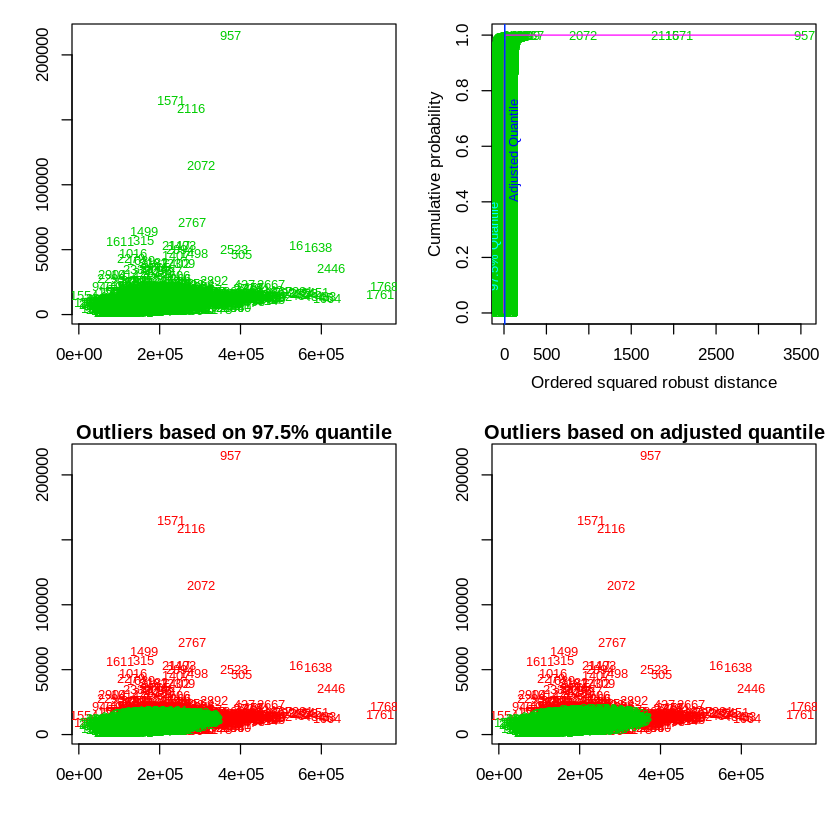

In [5]:
#using package is better, plus we get an adjusted quantile calculation and a nice graph
info <- mvoutlier::aq.plot(data.frame(AmesHousing$SalePrice, AmesHousing$'Lot Area'))



In [6]:
head(AmesHousing, 3)

mean(AmesHousing$'Lot Area')
mean(AmesHousing$'SalePrice')

#AmesHousing[957,c("Gr Liv Area", "___", "SalePrice")]
AmesHousing[957,c("Lot Area", "SalePrice")]

#note that row 957 has over 10x of an average lot area, yet a comparatively low price


Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,⋯,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1,0526301100,020,RL,141,31770,Pave,NA,IR1,Lvl,⋯,0,NA,NA,NA,0,5,2010,WD,Normal,215000
2,0526350040,020,RH,80,11622,Pave,NA,Reg,Lvl,⋯,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
3,0526351010,020,RL,81,14267,Pave,NA,IR1,Lvl,⋯,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000


[1] 10147.92

[1] 180796.1

Lot Area,SalePrice
215245,375000


In [7]:
#all outliers
AmesHousing$is_outlier <- info$outliers
# df with outliers for Lot Area and SalePrice
outliers <- AmesHousing %>% filter(is_outlier == TRUE)

#print few additional outliers
print("10 additional outliers")
head(AmesHousing[AmesHousing$is_outlier==TRUE, c("Order","Lot Area", "SalePrice","is_outlier")], 10)


[1] "10 additional outliers"


Order,Lot Area,SalePrice,is_outlier
1,31770,215000,TRUE
16,53504,538000,TRUE
18,11394,394432,TRUE
19,19138,141000,TRUE
37,12858,376162,TRUE
39,10159,395192,TRUE
45,12919,611657,TRUE
47,14300,500000,TRUE
61,17433,355000,TRUE
66,14720,410000,TRUE


-outliers: df with outliers for Lot Area and SalePrice<br>
-row 957 is an extreme outlier because it has a Lot Area that is >20x average, yet a comparatively low price (2x average SalePrice)